In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [ ]:
import torch
from torch.utils.data import Dataset
class DialogueDatasetCached(Dataset):
    def __init__(self, torch_path):
        data = torch.load(torch_path)

        self.utterance1 = data["utterance1"]
        self.utterance2 = data["utterance2"]
        self.responses = data["responses"]
        self.emotion1 = data["emotion1"]
        self.emotion2 = data["emotion2"]
        self.target_emotions = data["target_emotions"]

        self.personalities = data["personalities"]
        self.vad_personalities = data["vad_personalities"]

        self.vad_u1 = data["vad_u1"]
        self.vad_u2 = data["vad_u2"]
        self.vad_u3 = data["vad_u3"]
        self.vad_e1 = data["vad_e1"]
        self.vad_e2 = data["vad_e2"]
        self.vad_e3 = data["vad_e3"]

        self.context_embeddings_u1_u2 = data["context_embeddings_u1_u2"]
        self.context_embeddings_u1_u2_u3 = data["context_embeddings_u1_u2_u3"]

    def __len__(self):
        return len(self.utterance1)

    def __getitem__(self, idx):
        return {
            "utterance_1": self.utterance1[idx],
            "utterance_2": self.utterance2[idx],
            "utterance_3": self.responses[idx],
            "emotion_1": self.emotion1[idx],
            "emotion_2": self.emotion2[idx],
            "response": self.responses[idx],
            "target_emotion": self.target_emotions[idx],
            "personality": self.personalities[idx],
            "vad_personality": self.vad_personalities[idx],
            "vad_u1": self.vad_u1[idx],
            "vad_u2": self.vad_u2[idx],
            "vad_u3": self.vad_u3[idx],
            "vad_e1": self.vad_e1[idx],
            "vad_e2": self.vad_e2[idx],
            "vad_e3": self.vad_e3[idx],
            "context_embeddings_u1_u2": self.context_embeddings_u1_u2[idx],
            "context_embeddings_u1_u2_u3": self.context_embeddings_u1_u2_u3[idx]
        }


In [ ]:
from torch.utils.data import DataLoader

dataset = DialogueDatasetCached("dialogue_dataset_prepared_multihead_speaker_annotated.pt")
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [ ]:
dataset

In [ ]:
dataset[0]

{'utterance_1': 'also I was the point person on my company s transition from the KL-5 to GR-6 system.',
 'utterance_2': 'You must ve had your hands full.',
 'utterance_3': 'That I did. That I did.',
 'emotion_1': 'neutral',
 'emotion_2': 'neutral',
 'response': 'That I did. That I did.',
 'target_emotion': 'neutral',
 'personality': tensor([0.6480, 0.3750, 0.3860, 0.5800, 0.4770]),
 'vad_personality': tensor([ 0.5139, -0.0007,  0.2718]),
 'vad_u1': tensor([ 0.0847, -0.0726,  0.0750]),
 'vad_u2': tensor([ 0.0025, -0.0908,  0.0686]),
 'vad_u3': tensor([0.0000, 0.1860, 0.0000]),
 'vad_e1': tensor([0., 0., 0.]),
 'vad_e2': tensor([0., 0., 0.]),
 'vad_e3': tensor([0., 0., 0.]),
 'context_embeddings_u1_u2': tensor([-8.6855e-01, -3.4399e-02, -7.3367e-01,  3.0520e-02, -8.6093e-01,
         -4.7211e-04,  6.5669e-01,  5.1369e-01, -8.0192e-02, -1.5090e-01,
         -6.1407e-01, -7.5159e-03,  4.7931e-01,  5.9157e-01,  3.7618e-01,
         -4.6722e-02, -2.1006e-01,  5.0291e-01,  5.3193e-01, -4.5763

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import numpy as np

# Focal Loss for handling imbalanced emotion classes
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        F_loss = (1-pt)**self.gamma * CE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        else:
            return torch.sum(F_loss)

In [ ]:
# Define emotion to index mapping
emotion_to_idx = {
    'neutral': 0, 'joy': 1, 'anger': 2, 'sadness': 3,
    'fear': 4, 'disgust': 5, 'surprise': 6
}


In [ ]:
# Define mood domains in VAD space
Mood_dict = {
    # M4 is neutral
    'M4': [0.0, 0.0, 0.0],
    'M1': [1.0, 1.0, 0.0],
    'M2': [-1.0, 1.0, 0.0],
    'M3': [-1.0, -1.0, 0.0]
}

# Map emotions to mood domains
Emotion_Mood = {
    'anger': 'M2',
    'sadness': 'M3',
    'neutral': 'M4',
    'joy': 'M1',
    'surprise': 'M1',
    'fear': 'M2',
    'disgust': 'M2'
}

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F

def find_closest_mood(vad_vector, mood_dict):
    """
    vad_vector: torch.Tensor or np.array of shape (3,)
    mood_dict: dictionary with mood names as keys and VAD vectors as values
    returns: mood label with highest cosine similarity
    """

    if isinstance(vad_vector, np.ndarray):
        vad_vector = torch.tensor(vad_vector, dtype=torch.float32)

    vad_vector = F.normalize(vad_vector.unsqueeze(0), dim=1)  # shape [1, 3]

    mood_names = list(mood_dict.keys())
    mood_vectors = torch.tensor([mood_dict[m] for m in mood_names], dtype=torch.float32)
    mood_vectors = F.normalize(mood_vectors, dim=1)  # shape [num_moods, 3]

    cosine_sim = torch.matmul(vad_vector, mood_vectors.T).squeeze(0)  # shape [num_moods]
    best_idx = torch.argmax(cosine_sim).item()

    return mood_names[best_idx], cosine_sim[best_idx].item()


In [ ]:
def plot_eval(test_targets, test_preds):
  import matplotlib.pyplot as plt
  import numpy as np
  from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

  # Same simulated data as before
  idx_to_emotion = {v: k for k, v in emotion_to_idx.items()}

  # Metrics per class
  precision_per_class = precision_score(test_targets, test_preds, average=None, zero_division=0)
  recall_per_class = recall_score(test_targets, test_preds, average=None, zero_division=0)
  f1_per_class = f1_score(test_targets, test_preds, average=None, zero_division=0)
  accuracy_per_class = []

  # Compute per-class accuracy manually
  for i in range(len(emotion_to_idx)):
      class_indices = [j for j, x in enumerate(test_targets) if x == i]
      class_correct = sum(1 for j in class_indices if test_preds[j] == i)
      class_total = len(class_indices)
      acc = class_correct / class_total if class_total > 0 else 0.0
      accuracy_per_class.append(acc)

  # Overall metrics
  precision_avg = precision_score(test_targets, test_preds, average='macro')
  recall_avg = recall_score(test_targets, test_preds, average='macro')
  f1_avg = f1_score(test_targets, test_preds, average='macro')
  accuracy_avg = accuracy_score(test_targets, test_preds)

  # Plotting
  emotions = list(emotion_to_idx.keys())
  x = np.arange(len(emotions))

  plt.figure(figsize=(12, 6))
  plt.plot(x, precision_per_class, marker='o', label='Precision')
  plt.plot(x, recall_per_class, marker='s', label='Recall')
  plt.plot(x, f1_per_class, marker='^', label='F1 Score')
  plt.plot(x, accuracy_per_class, marker='x', label='Accuracy')

  # Add text labels for scores on points
  for i in x:
      plt.text(i, precision_per_class[i] + 0.02, f"{precision_per_class[i]:.2f}", ha='center', color='blue')
      plt.text(i, recall_per_class[i] + 0.02, f"{recall_per_class[i]:.2f}", ha='center', color='orange')
      plt.text(i, f1_per_class[i] + 0.02, f"{f1_per_class[i]:.2f}", ha='center', color='green')
      plt.text(i, accuracy_per_class[i] + 0.02, f"{accuracy_per_class[i]:.2f}", ha='center', color='red')

  # Plot averages as dashed lines
  plt.axhline(y=precision_avg, color='blue', linestyle='--', linewidth=1, label='Avg Precision')
  plt.axhline(y=recall_avg, color='orange', linestyle='--', linewidth=1, label='Avg Recall')
  plt.axhline(y=f1_avg, color='green', linestyle='--', linewidth=1, label='Avg F1 Score')
  plt.axhline(y=accuracy_avg, color='red', linestyle='--', linewidth=1, label='Avg Accuracy')

  plt.xticks(x, emotions)
  plt.ylim(0, 1.1)
  plt.xlabel("Emotions")
  plt.ylabel("Score")
  plt.title("Emotion-wise Precision, Recall, F1 Score, and Accuracy (with Values)")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  return


In [ ]:
class DialogEmotionDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Initial mood is average of previous utterance VADs
        initial_mood = torch.tensor(Mood_dict[Emotion_Mood[sample['emotion_1']]], dtype=torch.float32)
        target_mood = torch.tensor(Mood_dict[Emotion_Mood[sample['target_emotion']]], dtype=torch.float32)

        avg_utt_attention_vad = (sample['vad_u1'] + sample['vad_u2']) / 2.0
        avg_emotion_vad = (sample['vad_e1'] + sample['vad_e2']) / 2.0
        target_emotion = emotion_to_idx[sample['target_emotion']]

        return {
            'context_embed': sample['context_embeddings_u1_u2'],
            'context_embed_u1_u2_u3': sample['context_embeddings_u1_u2_u3'],
            'personality': sample['personality'],
            'vad_personality': sample['vad_personality'],
            'initial_mood': initial_mood,
            'target_mood': target_mood,
            'target_emotion': target_emotion,
            'avg_attention_vad': avg_utt_attention_vad,
            "avg_emotion_vad": avg_emotion_vad,
        }

# Split data and create dataloaders
def prepare_data(data, batch_size=16):
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

    # Create datasets
    train_dataset = DialogEmotionDataset(train_data)
    val_dataset = DialogEmotionDataset(val_data)
    test_dataset = DialogEmotionDataset(test_data)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Emotion → VAD mapping
EMOTION_TO_VAD = {
    'neutral': [0.00, 0.00, 0.00],
    'sadness': [-0.63, -0.27, -0.33],
    'joy': [0.81, 0.51, 0.46],
    'anger': [-0.51, 0.59, 0.25],
    'fear': [-0.62, 0.82, -0.43],
    'disgust': [-0.60, 0.35, 0.11],
    'surprise': [0.40, 0.67, -0.13]
}

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PersonalityEmotionModel(nn.Module):
    def __init__(self, context_dim, personality_dim, vad_dim, hidden_dim, num_emotions, dropout=0.2):
        super().__init__()

        # ========== Mood Transition Modules ==========

        # Input: [context + attention VAD + emotion VAD]
        self.delta_vad_layer = nn.Linear(context_dim + 2 * vad_dim, vad_dim)

        # Learn personality → VAD mapping
        self.personality_vad_map = nn.Linear(personality_dim, vad_dim)

        # Emotion-conditioned VAD shift
        self.emotion_vad_shift = nn.Linear(vad_dim * 2, vad_dim)

        # GRU over [initial_mood, p_vad, delta_vad]
        self.gru = nn.GRU(input_size=vad_dim, hidden_size=vad_dim, batch_first=True)

        # ========== Projection Modules ==========

        self.mood_projection = self._residual_projector(vad_dim, hidden_dim, dropout)
        self.personality_projection = self._residual_projector(personality_dim, hidden_dim, dropout)
        self.context_projection = self._residual_projector(context_dim, hidden_dim, dropout)

        # Final classifier
        self.emotion_classifier = nn.Linear(hidden_dim * 3, num_emotions)

    def _residual_projector(self, input_dim, hidden_dim, dropout):
        """Residual projection block with LayerNorm"""
        return nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.LayerNorm(hidden_dim)
        )

    def forward(self, context_embed, context_embed_u1_u2_u3, personality, vad_personality,
                initial_mood, attention_vad_embed, emotion_vad_embed):

        # ----- VAD Delta -----
        delta_input = torch.cat([context_embed_u1_u2_u3, attention_vad_embed, emotion_vad_embed], dim=1)
        delta_vad = torch.tanh(self.delta_vad_layer(delta_input))  # shape: [B, vad_dim]

        # ----- Personality → VAD -----
        p_vad = self.personality_vad_map(personality)  # [B, vad_dim]

        # ----- Emotion-conditioned VAD shift -----
        vad_emotion_concat = torch.cat([delta_vad, emotion_vad_embed], dim=1)
        delta_vad = torch.tanh(self.emotion_vad_shift(vad_emotion_concat))  # [B, vad_dim]

        # ----- GRU Mood Regression -----
        vad_seq = torch.stack([initial_mood, p_vad, delta_vad], dim=1)  # [B, 3, vad_dim]
        _, h_n = self.gru(vad_seq)  # h_n: [1, B, vad_dim]
        mood_r = h_n.squeeze(0)     # [B, vad_dim]

        # ----- Projections -----
        mood_features = self.mood_projection(mood_r)
        personality_features = self.personality_projection(personality)
        context_features = self.context_projection(context_embed)

        # ----- Classifier -----
        combined = torch.cat([mood_features, personality_features, context_features], dim=1)
        emotion_logits = self.emotion_classifier(combined)

        return emotion_logits, mood_r


In [ ]:
def compute_mood_logits_from_vad(vad_batch, mood_dict):
    """
    vad_batch: [batch_size, 3]
    mood_dict: dict of {label: [V, A, D]}
    returns: [batch_size, num_moods] cosine similarities
    """
    mood_names = list(mood_dict.keys())
    mood_matrix = torch.tensor([mood_dict[m] for m in mood_names], dtype=torch.float32).to(vad_batch.device)
    mood_matrix = F.normalize(mood_matrix, dim=1)  # [num_moods, 3]
    vad_batch = F.normalize(vad_batch, dim=1)      # [batch_size, 3]

    logits = torch.matmul(vad_batch, mood_matrix.T)  # [batch_size, num_moods]
    return logits, mood_names

In [ ]:
def train_model(model, train_loader, val_loader, device, num_epochs=20):
    # Set device
    model.to(device)

    # Loss and optimizer
    criterion = FocalLoss(gamma=2)  # Use focal loss for imbalanced classes
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    mse_loss = nn.MSELoss()

    best_f1 = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0

        for batch in train_loader:
            # Move to device
            context_embed = batch['context_embed'].to(device)
            context_embed_u1_u2_u3 = batch['context_embed_u1_u2_u3'].to(device)
            personality = batch['personality'].to(device)
            vad_personality = batch['vad_personality'].to(device)
            initial_mood = batch['initial_mood'].to(device)
            target_mood = batch['target_mood'].to(device)
            target_emotion = batch['target_emotion'].to(device)
            avg_attention_vad = batch['avg_attention_vad'].to(device)
            avg_emotion_vad  = batch['avg_emotion_vad'].to(device)

            # Forward pass
            optimizer.zero_grad()
            emotion_logits, mood_r = model(context_embed, context_embed, personality, vad_personality, initial_mood, avg_attention_vad, avg_emotion_vad)

            # Calculate loss
            emo_loss = criterion(emotion_logits, target_emotion)
            mood_loss = mse_loss(mood_r, target_mood)
            loss = emo_loss + mood_loss

            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_preds, val_targets = [], []

        with torch.no_grad():
            for batch in val_loader:
                # Move to device
                context_embed = batch['context_embed'].to(device)
                context_embed_u1_u2_u3 = batch['context_embed_u1_u2_u3'].to(device)
                personality = batch['personality'].to(device)
                vad_personality = batch['vad_personality'].to(device)
                initial_mood = batch['initial_mood'].to(device)
                target_mood = batch['target_mood'].to(device)
                target_emotion = batch['target_emotion'].to(device)
                avg_attention_vad = batch['avg_attention_vad'].to(device)
                avg_emotion_vad  = batch['avg_emotion_vad'].to(device)

                # Forward pass
                emotion_logits, _ = model(context_embed, context_embed, personality, vad_personality, initial_mood, avg_attention_vad, avg_emotion_vad)

                _, preds = torch.max(emotion_logits, 1)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(target_emotion.cpu().numpy())

        # Calculate F1 score
        val_f1 = f1_score(val_targets, val_preds, average='weighted')

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}, Val F1: {val_f1:.4f}')

        # Save best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'best_emotion_model.pt')

    # Load best model
    model.load_state_dict(torch.load('best_emotion_model.pt'))
    return model

def evaluate_model(model, test_loader, device):
    model.eval()
    test_preds, test_targets = [], []
    plotted = False  # to plot only once

    idx_to_emotion = {v: k for k, v in emotion_to_idx.items()}

    with torch.no_grad():
        for batch in test_loader:
            # Process batch
            context_embed = batch['context_embed'].to(device)
            context_embed_u1_u2_u3 = batch['context_embed_u1_u2_u3'].to(device)
            personality = batch['personality'].to(device)
            vad_personality = batch['vad_personality'].to(device)
            initial_mood = batch['initial_mood'].to(device)
            target_emotion = batch['target_emotion'].to(device)
            avg_attention_vad = batch['avg_attention_vad'].to(device)
            avg_emotion_vad  = batch['avg_emotion_vad'].to(device)
            temperature = 0.8
            # Forward pass
            emotion_logits, _ = model(context_embed, context_embed, personality, vad_personality, initial_mood, avg_attention_vad, avg_emotion_vad)
            scaled_logits = emotion_logits / temperature
            _, preds = torch.max(scaled_logits, 1)

            # _, preds = torch.max(emotion_logits, 1)
            test_preds.extend(preds.cpu().numpy())
            test_targets.extend(target_emotion.cpu().numpy())

    classification_report_str = classification_report(test_targets, test_preds)
    print(classification_report_str)

    # Calculate F1 scores
    f1_weighted = f1_score(test_targets, test_preds, average='weighted')
    f1_macro = f1_score(test_targets, test_preds, average='macro')
    f1_micro = f1_score(test_targets, test_preds, average='micro')
    f1_per_class = f1_score(test_targets, test_preds, average=None)

    # Print results
    print(f'Test F1 Score (Weighted): {f1_weighted:.4f}')

    print(f'Test F1 Score (Macro): {f1_macro:.4f}')
    print(f'Test F1 Score (Micro): {f1_micro:.4f}')
    for i, f1 in enumerate(f1_per_class):
        emotion = list(emotion_to_idx.keys())[i]
        print(f'F1 Score for {emotion}: {f1:.4f}')
    plot_eval(test_targets, test_preds)

    return f1_weighted, f1_macro, f1_micro, f1_per_class



PersonalityEmotionModel(
  (delta_vad_layer): Linear(in_features=774, out_features=3, bias=True)
  (personality_vad_map): Linear(in_features=5, out_features=3, bias=True)
  (emotion_vad_shift): Linear(in_features=6, out_features=3, bias=True)
  (gru): GRU(3, 3, batch_first=True)
  (mood_projection): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (personality_projection): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (context_projection): Sequential(
    (0): Linear(in_features=768, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (emotion_classifier): Linear(in_features=192, out_features=7, bias=

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

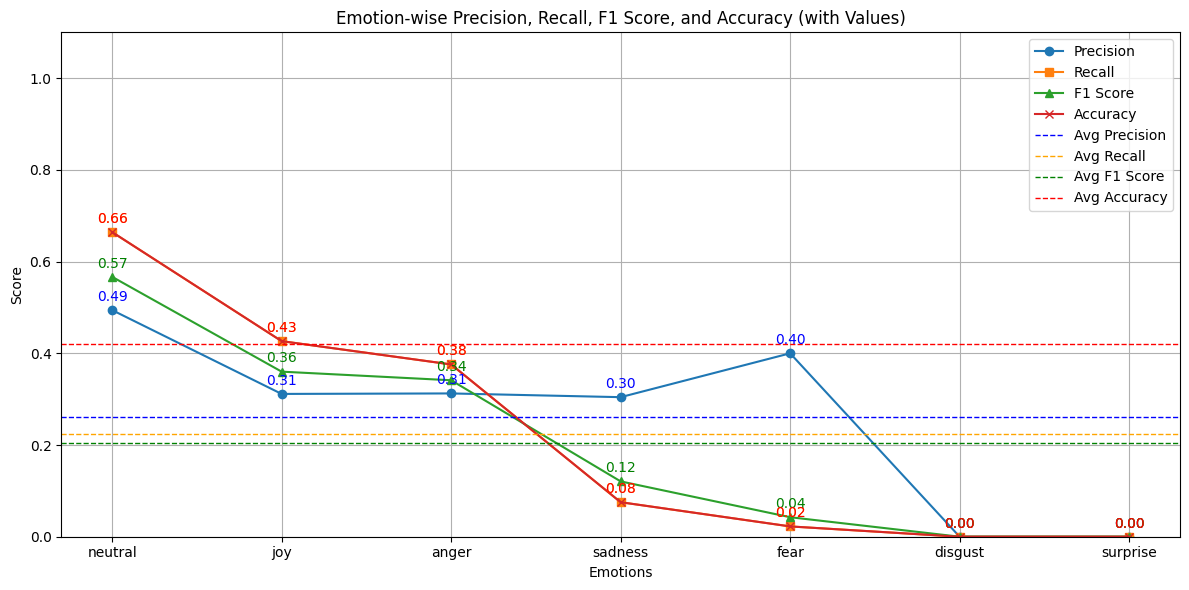

In [ ]:
# Softmax, U3 in train, 10 epochs - GRU, regularixzation, .., 0.8 temperature
def main():
    from torch.utils.data import DataLoader
    dataset = DialogueDatasetCached("dialogue_dataset_prepared_multihead_speaker_annotated.pt")
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your data here
    # For this example, we'll use the sample provided
    data = dataset  # Replace with actual data loading

    # Prepare data
    train_loader, val_loader, test_loader = prepare_data(data)

    # Initialize model
    sample = data[0]
    context_dim = sample['context_embeddings_u1_u2'].size(0)
    personality_dim = sample['personality'].size(0)
    vad_dim = sample['vad_personality'].size(0)
    hidden_dim = 64

    model = PersonalityEmotionModel(
        context_dim, personality_dim, vad_dim, hidden_dim, len(emotion_to_idx)
    )
    print(model)

    # Train model
    model = train_model(model, train_loader, val_loader, device, 20)

    # Evaluate model
    f1_weighted, f1_macro, f1_micro, f1_per_class = evaluate_model(model, test_loader, device)

    return f1_weighted, f1_macro, f1_micro, f1_per_class

if __name__ == '__main__':
    main()


PersonalityEmotionModel(
  (delta_vad_layer): Linear(in_features=774, out_features=3, bias=True)
  (personality_vad_map): Linear(in_features=5, out_features=3, bias=True)
  (emotion_vad_shift): Linear(in_features=6, out_features=3, bias=True)
  (gru): GRU(3, 3, batch_first=True)
  (mood_projection): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (personality_projection): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (context_projection): Sequential(
    (0): Linear(in_features=768, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (emotion_classifier): Linear(in_features=192, out_features=7, bias=

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

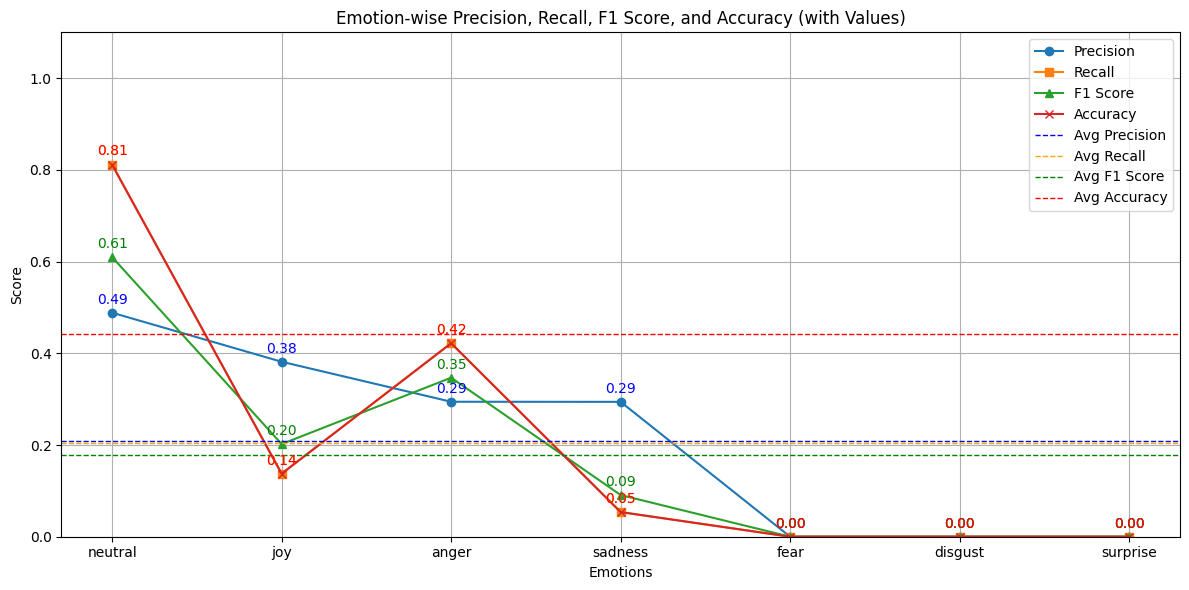

In [ ]:
# Softmax, U3 in train, 10 epochs - GRU, regularixzation, .., 1.5 temperature
def main():
    from torch.utils.data import DataLoader
    dataset = DialogueDatasetCached("dialogue_dataset_prepared_multihead_speaker_annotated.pt")
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your data here
    # For this example, we'll use the sample provided
    data = dataset  # Replace with actual data loading

    # Prepare data
    train_loader, val_loader, test_loader = prepare_data(data)

    # Initialize model
    sample = data[0]
    context_dim = sample['context_embeddings_u1_u2'].size(0)
    personality_dim = sample['personality'].size(0)
    vad_dim = sample['vad_personality'].size(0)
    hidden_dim = 64

    model = PersonalityEmotionModel(
        context_dim, personality_dim, vad_dim, hidden_dim, len(emotion_to_idx)
    )
    print(model)

    # Train model
    model = train_model(model, train_loader, val_loader, device, 20)

    # Evaluate model
    f1_weighted, f1_macro, f1_micro, f1_per_class = evaluate_model(model, test_loader, device)

    return f1_weighted, f1_macro, f1_micro, f1_per_class

if __name__ == '__main__':
    main()


PersonalityEmotionModel(
  (delta_vad_layer): Linear(in_features=774, out_features=3, bias=True)
  (personality_vad_map): Linear(in_features=5, out_features=3, bias=True)
  (emotion_vad_shift): Linear(in_features=6, out_features=3, bias=True)
  (gru): GRU(3, 3, batch_first=True)
  (mood_projection): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (personality_projection): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (context_projection): Sequential(
    (0): Linear(in_features=768, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (emotion_classifier): Linear(in_features=192, out_features=7, bias=

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

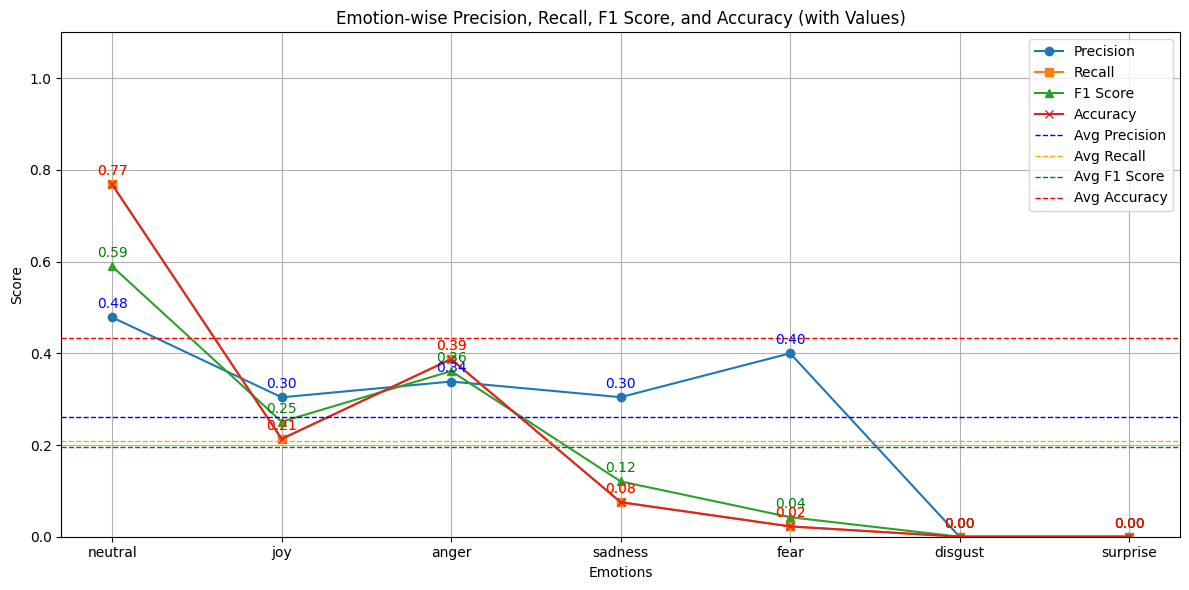

In [ ]:
# Softmax, U3 in train, 10 epochs - GRU, regularixzation, .., 0.8, 0.2 weighted
def main():
    from torch.utils.data import DataLoader
    dataset = DialogueDatasetCached("dialogue_dataset_prepared_multihead_speaker_annotated.pt")
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your data here
    # For this example, we'll use the sample provided
    data = dataset  # Replace with actual data loading

    # Prepare data
    train_loader, val_loader, test_loader = prepare_data(data)

    # Initialize model
    sample = data[0]
    context_dim = sample['context_embeddings_u1_u2'].size(0)
    personality_dim = sample['personality'].size(0)
    vad_dim = sample['vad_personality'].size(0)
    hidden_dim = 64

    model = PersonalityEmotionModel(
        context_dim, personality_dim, vad_dim, hidden_dim, len(emotion_to_idx)
    )
    print(model)

    # Train model
    model = train_model(model, train_loader, val_loader, device, 20)

    # Evaluate model
    f1_weighted, f1_macro, f1_micro, f1_per_class = evaluate_model(model, test_loader, device)

    return f1_weighted, f1_macro, f1_micro, f1_per_class

if __name__ == '__main__':
    main()


PersonalityEmotionModel(
  (delta_vad_layer): Linear(in_features=774, out_features=3, bias=True)
  (personality_vad_map): Linear(in_features=5, out_features=3, bias=True)
  (emotion_vad_shift): Linear(in_features=6, out_features=3, bias=True)
  (gru): GRU(3, 3, batch_first=True)
  (mood_projection): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (personality_projection): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (context_projection): Sequential(
    (0): Linear(in_features=768, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (emotion_classifier): Linear(in_features=192, out_features=7, bias=

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

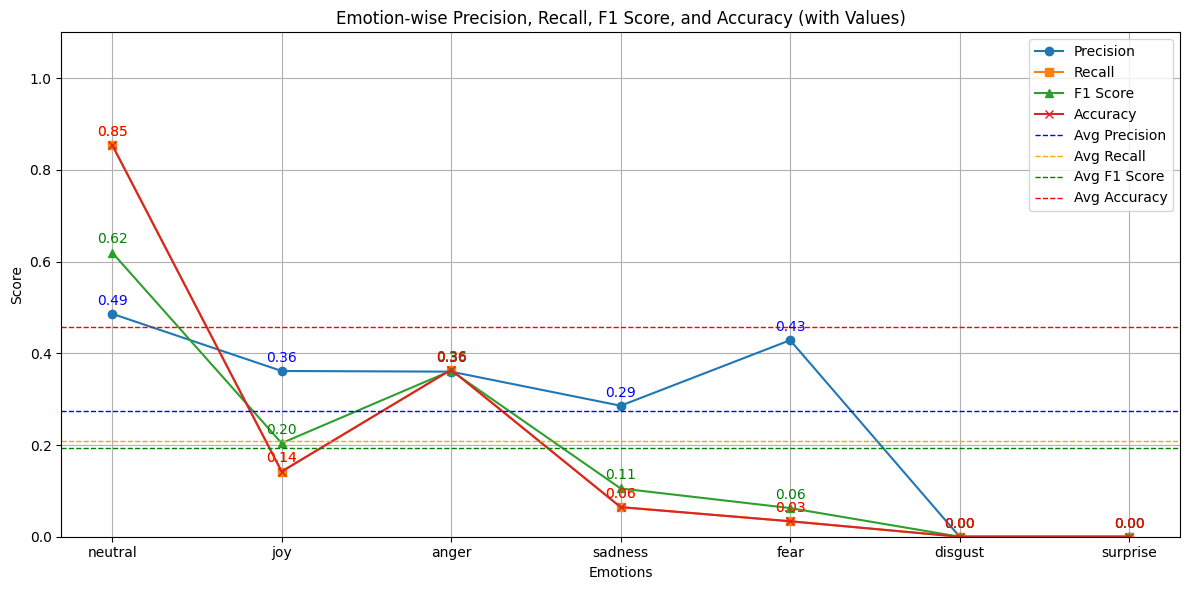

In [ ]:
# Softmax, U3 nowhere, 20 epochs - GRU, regularixzation, ..
def main():
    from torch.utils.data import DataLoader
    dataset = DialogueDatasetCached("dialogue_dataset_prepared_multihead_speaker_annotated.pt")
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your data here
    # For this example, we'll use the sample provided
    data = dataset  # Replace with actual data loading

    # Prepare data
    train_loader, val_loader, test_loader = prepare_data(data)

    # Initialize model
    sample = data[0]
    context_dim = sample['context_embeddings_u1_u2'].size(0)
    personality_dim = sample['personality'].size(0)
    vad_dim = sample['vad_personality'].size(0)
    hidden_dim = 64

    model = PersonalityEmotionModel(
        context_dim, personality_dim, vad_dim, hidden_dim, len(emotion_to_idx)
    )
    print(model)

    # Train model
    model = train_model(model, train_loader, val_loader, device, 20)

    # Evaluate model
    f1_weighted, f1_macro, f1_micro, f1_per_class = evaluate_model(model, test_loader, device)

    return f1_weighted, f1_macro, f1_micro, f1_per_class

if __name__ == '__main__':
    main()


PersonalityEmotionModel(
  (delta_vad_layer): Linear(in_features=774, out_features=3, bias=True)
  (personality_vad_map): Linear(in_features=5, out_features=3, bias=True)
  (gru): GRU(3, 3, batch_first=True)
  (mood_projection): Linear(in_features=3, out_features=64, bias=True)
  (personality_projection): Linear(in_features=5, out_features=64, bias=True)
  (context_projection): Linear(in_features=768, out_features=64, bias=True)
  (emotion_classifier): Linear(in_features=192, out_features=7, bias=True)
)
Epoch 1/50, Loss: 1.5055, Val F1: 0.2455
Epoch 2/50, Loss: 1.4203, Val F1: 0.2476
Epoch 3/50, Loss: 1.3860, Val F1: 0.2599
Epoch 4/50, Loss: 1.3703, Val F1: 0.2826
Epoch 5/50, Loss: 1.3682, Val F1: 0.2968
Epoch 6/50, Loss: 1.3622, Val F1: 0.3032
Epoch 7/50, Loss: 1.3550, Val F1: 0.2916
Epoch 8/50, Loss: 1.3442, Val F1: 0.3079
Epoch 9/50, Loss: 1.3353, Val F1: 0.3534
Epoch 10/50, Loss: 1.3415, Val F1: 0.3104
Epoch 11/50, Loss: 1.3246, Val F1: 0.3227
Epoch 12/50, Loss: 1.3233, Val F1: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

              precision    recall  f1-score   support

           0       0.48      0.75      0.58       578
           1       0.28      0.24      0.26       211
           2       0.33      0.31      0.32       173
           3       0.25      0.02      0.04        93
           4       0.20      0.04      0.07        89
           5       0.00      0.00      0.00        30
           6       0.22      0.05      0.08       128

    accuracy                           0.42      1302
   macro avg       0.25      0.20      0.19      1302
weighted avg       0.35      0.42      0.36      1302

Test F1 Score (Weighted): 0.3589
Test F1 Score (Macro): 0.1933
Test F1 Score (Micro): 0.4209
F1 Score for neutral: 0.5832
F1 Score for joy: 0.2589
F1 Score for anger: 0.3205
F1 Score for sadness: 0.0396
F1 Score for fear: 0.0734
F1 Score for disgust: 0.0000
F1 Score for surprise: 0.0774


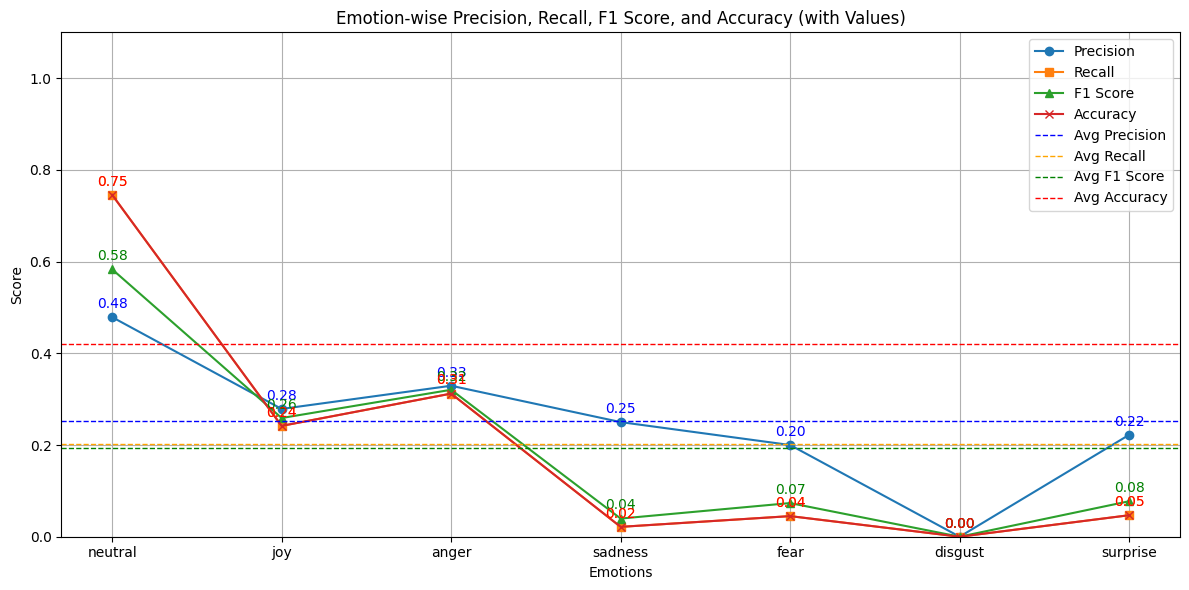

In [ ]:
# Softmax, U3 in train, 50 epochs - GRU
def main():
    from torch.utils.data import DataLoader
    dataset = DialogueDatasetCached("dialogue_dataset_prepared_multihead_speaker_annotated.pt")
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your data here
    # For this example, we'll use the sample provided
    data = dataset  # Replace with actual data loading

    # Prepare data
    train_loader, val_loader, test_loader = prepare_data(data)

    # Initialize model
    sample = data[0]
    context_dim = sample['context_embeddings_u1_u2'].size(0)
    personality_dim = sample['personality'].size(0)
    vad_dim = sample['vad_personality'].size(0)
    hidden_dim = 64

    model = PersonalityEmotionModel(
        context_dim, personality_dim, vad_dim, hidden_dim, len(emotion_to_idx)
    )
    print(model)

    # Train model
    model = train_model(model, train_loader, val_loader, device, 50)

    # Evaluate model
    f1_weighted, f1_macro, f1_micro, f1_per_class = evaluate_model(model, test_loader, device)

    return f1_weighted, f1_macro, f1_micro, f1_per_class

if __name__ == '__main__':
    main()


Epoch 1/20, Loss: 1.5722, Val F1: 0.2492
Epoch 2/20, Loss: 1.5262, Val F1: 0.3183
Epoch 3/20, Loss: 1.5118, Val F1: 0.2459
Epoch 4/20, Loss: 1.5091, Val F1: 0.2590
Epoch 5/20, Loss: 1.4937, Val F1: 0.3173
Epoch 6/20, Loss: 1.4806, Val F1: 0.2688
Epoch 7/20, Loss: 1.4753, Val F1: 0.3028
Epoch 8/20, Loss: 1.4609, Val F1: 0.2765
Epoch 9/20, Loss: 1.4474, Val F1: 0.3289
Epoch 10/20, Loss: 1.4346, Val F1: 0.3539
Epoch 11/20, Loss: 1.4363, Val F1: 0.3255
Epoch 12/20, Loss: 1.4165, Val F1: 0.3243
Epoch 13/20, Loss: 1.4139, Val F1: 0.3339
Epoch 14/20, Loss: 1.4116, Val F1: 0.3441
Epoch 15/20, Loss: 1.3918, Val F1: 0.3189
Epoch 16/20, Loss: 1.4023, Val F1: 0.3282
Epoch 17/20, Loss: 1.3940, Val F1: 0.3163
Epoch 18/20, Loss: 1.3662, Val F1: 0.3239
Epoch 19/20, Loss: 1.3619, Val F1: 0.3282
Epoch 20/20, Loss: 1.3582, Val F1: 0.3076
              precision    recall  f1-score   support

           0       0.49      0.79      0.60       578
           1       0.33      0.16      0.22       211
      

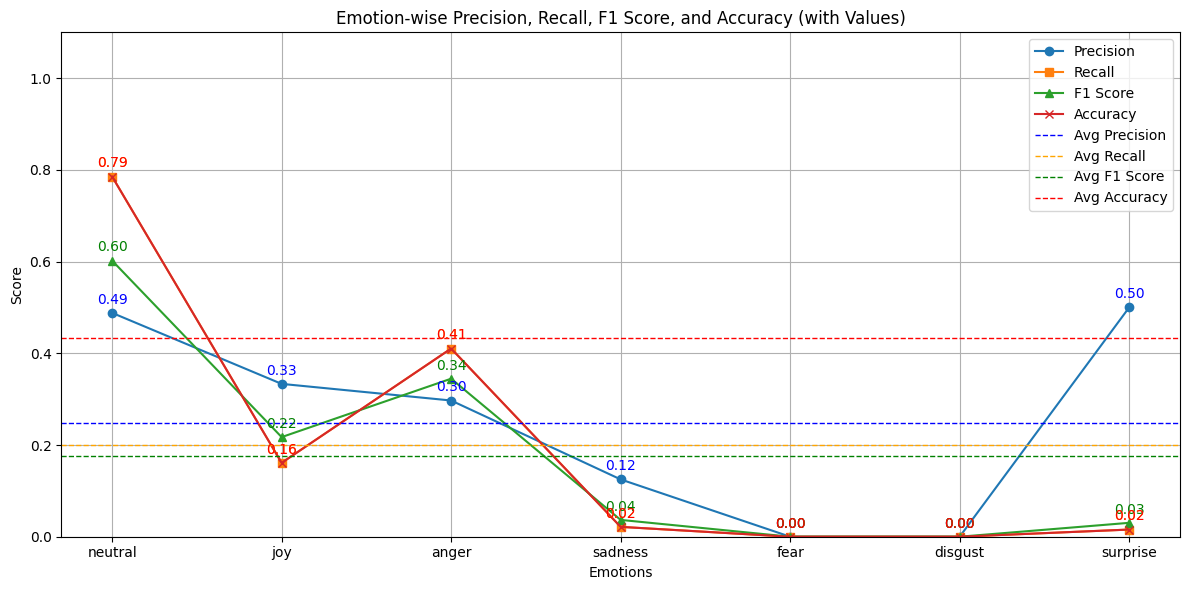

In [ ]:
# Softmax, U3 in train, 20 epochs -
def main():
    from torch.utils.data import DataLoader
    dataset = DialogueDatasetCached("dialogue_dataset_prepared_multihead_speaker_annotated.pt")
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your data here
    # For this example, we'll use the sample provided
    data = dataset  # Replace with actual data loading

    # Prepare data
    train_loader, val_loader, test_loader = prepare_data(data)

    # Initialize model
    sample = data[0]
    context_dim = sample['context_embeddings_u1_u2'].size(0)
    personality_dim = sample['personality'].size(0)
    vad_dim = sample['vad_personality'].size(0)
    hidden_dim = 64

    model = PersonalityEmotionModel(
        context_dim, personality_dim, vad_dim, hidden_dim, len(emotion_to_idx)
    )

    # Train model
    model = train_model(model, train_loader, val_loader, device, 20)

    # Evaluate model
    f1_weighted, f1_macro, f1_micro, f1_per_class = evaluate_model(model, test_loader, device)

    return f1_weighted, f1_macro, f1_micro, f1_per_class

if __name__ == '__main__':
    main()


Epoch 1/20, Loss: 1.6856, Val F1: 0.3162
Epoch 2/20, Loss: 1.5635, Val F1: 0.3121
Epoch 3/20, Loss: 1.5278, Val F1: 0.3270
Epoch 4/20, Loss: 1.5151, Val F1: 0.2616
Epoch 5/20, Loss: 1.5154, Val F1: 0.3093
Epoch 6/20, Loss: 1.4944, Val F1: 0.3132
Epoch 7/20, Loss: 1.4840, Val F1: 0.3105
Epoch 8/20, Loss: 1.4786, Val F1: 0.3577
Epoch 9/20, Loss: 1.4654, Val F1: 0.3534
Epoch 10/20, Loss: 1.4702, Val F1: 0.3328
Epoch 11/20, Loss: 1.4645, Val F1: 0.3002
Epoch 12/20, Loss: 1.4625, Val F1: 0.3386
Epoch 13/20, Loss: 1.4490, Val F1: 0.3199
Epoch 14/20, Loss: 1.4511, Val F1: 0.3359
Epoch 15/20, Loss: 1.4580, Val F1: 0.3262
Epoch 16/20, Loss: 1.4348, Val F1: 0.2762
Epoch 17/20, Loss: 1.4423, Val F1: 0.3440
Epoch 18/20, Loss: 1.4402, Val F1: 0.3480
Epoch 19/20, Loss: 1.4154, Val F1: 0.3279
Epoch 20/20, Loss: 1.4226, Val F1: 0.3312
              precision    recall  f1-score   support

           0       0.49      0.77      0.59       578
           1       0.28      0.20      0.23       211
      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

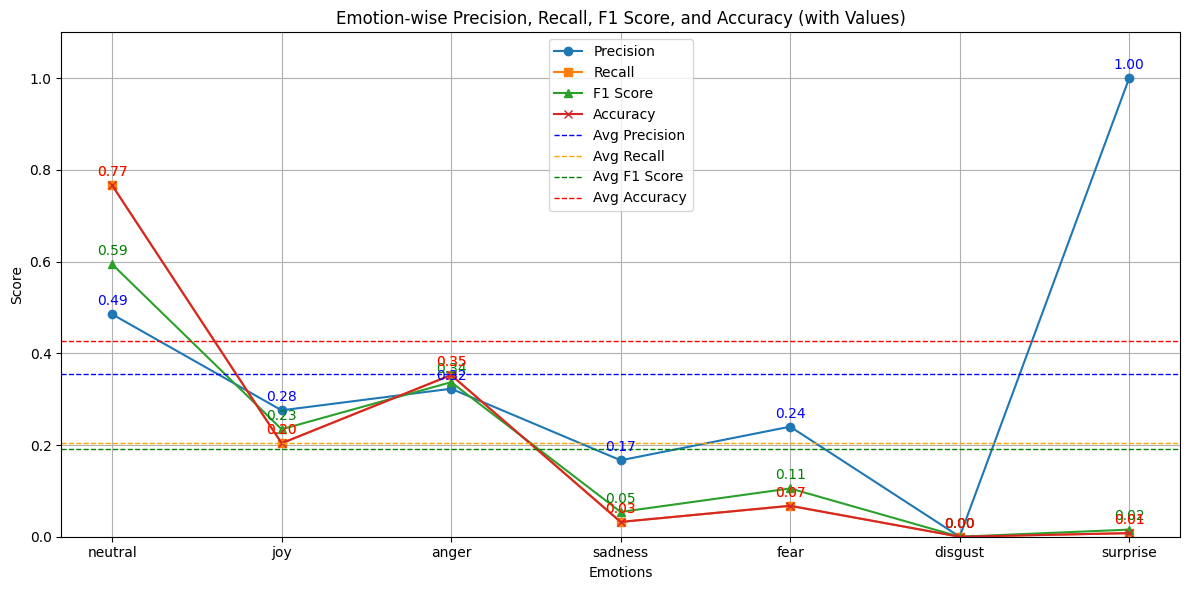

In [ ]:
# Softmax, U3 in train, 20 epochs
def main():
    from torch.utils.data import DataLoader
    dataset = DialogueDatasetCached("dialogue_dataset_prepared_multihead_speaker_annotated.pt")
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your data here
    # For this example, we'll use the sample provided
    data = dataset  # Replace with actual data loading

    # Prepare data
    train_loader, val_loader, test_loader = prepare_data(data)

    # Initialize model
    sample = data[0]
    context_dim = sample['context_embeddings_u1_u2'].size(0)
    personality_dim = sample['personality'].size(0)
    vad_dim = sample['vad_personality'].size(0)
    hidden_dim = 64

    model = PersonalityEmotionModel(
        context_dim, personality_dim, vad_dim, hidden_dim, len(emotion_to_idx)
    )

    # Train model
    model = train_model(model, train_loader, val_loader, device, 20)

    # Evaluate model
    f1_weighted, f1_macro, f1_micro, f1_per_class = evaluate_model(model, test_loader, device)

    return f1_weighted, f1_macro, f1_micro, f1_per_class

if __name__ == '__main__':
    main()


In [ ]:
# Softmax, U3 in train, 20 epochs
def main():
    from torch.utils.data import DataLoader
    dataset = DialogueDatasetCached("dialogue_dataset_prepared_multihead_speaker_annotated.pt")
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your data here
    # For this example, we'll use the sample provided
    data = dataset  # Replace with actual data loading

    # Prepare data
    train_loader, val_loader, test_loader = prepare_data(data)

    # Initialize model
    sample = data[0]
    context_dim = sample['context_embeddings_u1_u2'].size(0)
    personality_dim = sample['personality'].size(0)
    vad_dim = sample['vad_personality'].size(0)
    hidden_dim = 64

    model = PersonalityEmotionModel(
        context_dim, personality_dim, vad_dim, hidden_dim, len(emotion_to_idx)
    )

    # Train model
    model = train_model(model, train_loader, val_loader, device, 20)

    # Evaluate model
    f1_weighted, f1_macro, f1_micro, f1_per_class = evaluate_model(model, test_loader, device)

    return f1_weighted, f1_macro, f1_micro, f1_per_class

if __name__ == '__main__':
    main()


Epoch 1/20, Loss: 1.6421, Val F1: 0.2741
Epoch 2/20, Loss: 1.5579, Val F1: 0.2514
Epoch 3/20, Loss: 1.5306, Val F1: 0.2860
Epoch 4/20, Loss: 1.5211, Val F1: 0.3012
Epoch 5/20, Loss: 1.5094, Val F1: 0.2589
Epoch 6/20, Loss: 1.4988, Val F1: 0.3051
Epoch 7/20, Loss: 1.4904, Val F1: 0.3230
Epoch 8/20, Loss: 1.4700, Val F1: 0.3177
Epoch 9/20, Loss: 1.4649, Val F1: 0.3455
Epoch 10/20, Loss: 1.4580, Val F1: 0.3411
Epoch 11/20, Loss: 1.4681, Val F1: 0.3152
Epoch 12/20, Loss: 1.4572, Val F1: 0.3389
Epoch 13/20, Loss: 1.4469, Val F1: 0.2961
Epoch 14/20, Loss: 1.4473, Val F1: 0.3390
Epoch 15/20, Loss: 1.4389, Val F1: 0.3296
Epoch 16/20, Loss: 1.4327, Val F1: 0.3207
Epoch 17/20, Loss: 1.4286, Val F1: 0.3428
Epoch 18/20, Loss: 1.4336, Val F1: 0.3154
Epoch 19/20, Loss: 1.4244, Val F1: 0.3347
Epoch 20/20, Loss: 1.4327, Val F1: 0.3298
              precision    recall  f1-score   support

           0       0.47      0.86      0.61       578
           1       0.30      0.20      0.24       211
      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Softmax, U3 in all, 20 epochs
def main():
    from torch.utils.data import DataLoader
    dataset = DialogueDatasetCached("dialogue_dataset_prepared_multihead_speaker_annotated.pt")
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your data here
    # For this example, we'll use the sample provided
    data = dataset  # Replace with actual data loading

    # Prepare data
    train_loader, val_loader, test_loader = prepare_data(data)

    # Initialize model
    sample = data[0]
    context_dim = sample['context_embeddings_u1_u2'].size(0)
    personality_dim = sample['personality'].size(0)
    vad_dim = sample['vad_personality'].size(0)
    hidden_dim = 64

    model = PersonalityEmotionModel(
        context_dim, personality_dim, vad_dim, hidden_dim, len(emotion_to_idx)
    )

    # Train model
    model = train_model(model, train_loader, val_loader, device, 20)

    # Evaluate model
    f1_weighted, f1_macro, f1_micro, f1_per_class = evaluate_model(model, test_loader, device)

    return f1_weighted, f1_macro, f1_micro, f1_per_class

if __name__ == '__main__':
    main()


Epoch 1/20, Loss: 1.6096, Val F1: 0.3074
Epoch 2/20, Loss: 1.5760, Val F1: 0.3438
Epoch 3/20, Loss: 1.5347, Val F1: 0.3217
Epoch 4/20, Loss: 1.5181, Val F1: 0.3361
Epoch 5/20, Loss: 1.5099, Val F1: 0.2755
Epoch 6/20, Loss: 1.5017, Val F1: 0.3336
Epoch 7/20, Loss: 1.4784, Val F1: 0.3459
Epoch 8/20, Loss: 1.4731, Val F1: 0.3039
Epoch 9/20, Loss: 1.4630, Val F1: 0.3075
Epoch 10/20, Loss: 1.4619, Val F1: 0.3602
Epoch 11/20, Loss: 1.4621, Val F1: 0.3579
Epoch 12/20, Loss: 1.4490, Val F1: 0.3332
Epoch 13/20, Loss: 1.4470, Val F1: 0.3550
Epoch 14/20, Loss: 1.4558, Val F1: 0.3217
Epoch 15/20, Loss: 1.4504, Val F1: 0.3287
Epoch 16/20, Loss: 1.4302, Val F1: 0.3189
Epoch 17/20, Loss: 1.4302, Val F1: 0.3471
Epoch 18/20, Loss: 1.4373, Val F1: 0.3124
Epoch 19/20, Loss: 1.4190, Val F1: 0.3230
Epoch 20/20, Loss: 1.4234, Val F1: 0.3035
              precision    recall  f1-score   support

           0       0.51      0.61      0.56       578
           1       0.27      0.44      0.33       211
      

In [ ]:
# Tanh, no U3 in val,train, 200 epochs
def main():
    from torch.utils.data import DataLoader
    dataset = DialogueDatasetCached("dialogue_dataset_prepared_multihead_speaker_annotated.pt")
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your data here
    # For this example, we'll use the sample provided
    data = dataset  # Replace with actual data loading

    # Prepare data
    train_loader, val_loader, test_loader = prepare_data(data)

    # Initialize model
    sample = data[0]
    context_dim = sample['context_embeddings_u1_u2'].size(0)
    personality_dim = sample['personality'].size(0)
    vad_dim = sample['vad_personality'].size(0)
    hidden_dim = 64

    model = PersonalityEmotionModel(
        context_dim, personality_dim, vad_dim, hidden_dim, len(emotion_to_idx)
    )

    # Train model
    model = train_model(model, train_loader, val_loader, device, 200)

    # Evaluate model
    f1_weighted, f1_macro, f1_micro, f1_per_class = evaluate_model(model, test_loader, device)

    return f1_weighted, f1_macro, f1_micro, f1_per_class

if __name__ == '__main__':
    main()


Epoch 1/200, Loss: 1.6059, Val F1: 0.2457
Epoch 2/200, Loss: 1.5531, Val F1: 0.2669
Epoch 3/200, Loss: 1.5170, Val F1: 0.2572
Epoch 4/200, Loss: 1.4909, Val F1: 0.3201
Epoch 5/200, Loss: 1.4889, Val F1: 0.3056
Epoch 6/200, Loss: 1.4473, Val F1: 0.3046
Epoch 7/200, Loss: 1.4315, Val F1: 0.3038
Epoch 8/200, Loss: 1.4343, Val F1: 0.2578
Epoch 9/200, Loss: 1.4068, Val F1: 0.3092
Epoch 10/200, Loss: 1.4144, Val F1: 0.3284
Epoch 11/200, Loss: 1.3927, Val F1: 0.3220
Epoch 12/200, Loss: 1.3826, Val F1: 0.3320
Epoch 13/200, Loss: 1.3890, Val F1: 0.3049
Epoch 14/200, Loss: 1.3751, Val F1: 0.3204
Epoch 15/200, Loss: 1.3661, Val F1: 0.3432
Epoch 16/200, Loss: 1.3760, Val F1: 0.2695
Epoch 17/200, Loss: 1.3635, Val F1: 0.2890
Epoch 18/200, Loss: 1.3566, Val F1: 0.2846
Epoch 19/200, Loss: 1.3471, Val F1: 0.3070
Epoch 20/200, Loss: 1.3422, Val F1: 0.3098
Epoch 21/200, Loss: 1.3350, Val F1: 0.3187
Epoch 22/200, Loss: 1.3330, Val F1: 0.3311
Epoch 23/200, Loss: 1.3320, Val F1: 0.2959
Epoch 24/200, Loss: 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Softmax, no U3 in val, 20 epochs,  personality learnable layer
def main():
    from torch.utils.data import DataLoader
    dataset = DialogueDatasetCached("dialogue_dataset_prepared_multihead_speaker_annotated.pt")
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your data here
    # For this example, we'll use the sample provided
    data = dataset  # Replace with actual data loading

    # Prepare data
    train_loader, val_loader, test_loader = prepare_data(data)

    # Initialize model
    sample = data[0]
    context_dim = sample['context_embeddings_u1_u2'].size(0)
    personality_dim = sample['personality'].size(0)
    vad_dim = sample['vad_personality'].size(0)
    hidden_dim = 64

    model = PersonalityEmotionModel(
        context_dim, personality_dim, vad_dim, hidden_dim, len(emotion_to_idx)
    )

    # Train model
    model = train_model(model, train_loader, val_loader, device, 20)

    # Evaluate model
    f1_weighted, f1_macro, f1_micro, f1_per_class = evaluate_model(model, test_loader, device)

    return f1_weighted, f1_macro, f1_micro, f1_per_class

if __name__ == '__main__':
    main()


Epoch 1/20, Loss: 1.7026, Val F1: 0.2568
Epoch 2/20, Loss: 1.5696, Val F1: 0.2861
Epoch 3/20, Loss: 1.5356, Val F1: 0.2538
Epoch 4/20, Loss: 1.5249, Val F1: 0.3142
Epoch 5/20, Loss: 1.5095, Val F1: 0.3424
Epoch 6/20, Loss: 1.4975, Val F1: 0.2940
Epoch 7/20, Loss: 1.4923, Val F1: 0.3568
Epoch 8/20, Loss: 1.4848, Val F1: 0.3184
Epoch 9/20, Loss: 1.4670, Val F1: 0.3502
Epoch 10/20, Loss: 1.4712, Val F1: 0.3128
Epoch 11/20, Loss: 1.4547, Val F1: 0.3617
Epoch 12/20, Loss: 1.4590, Val F1: 0.3216
Epoch 13/20, Loss: 1.4532, Val F1: 0.2944
Epoch 14/20, Loss: 1.4605, Val F1: 0.3159
Epoch 15/20, Loss: 1.4491, Val F1: 0.3085
Epoch 16/20, Loss: 1.4322, Val F1: 0.3476
Epoch 17/20, Loss: 1.4331, Val F1: 0.3125
Epoch 18/20, Loss: 1.4307, Val F1: 0.3340
Epoch 19/20, Loss: 1.4286, Val F1: 0.3593
Epoch 20/20, Loss: 1.4181, Val F1: 0.3361
              precision    recall  f1-score   support

           0       0.48      0.77      0.59       578
           1       0.28      0.18      0.22       211
      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Softmax, no U3 in val, 20 epochs, without personality learnable layer
def main():
    from torch.utils.data import DataLoader
    dataset = DialogueDatasetCached("dialogue_dataset_prepared_multihead_speaker_annotated.pt")
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your data here
    # For this example, we'll use the sample provided
    data = dataset  # Replace with actual data loading

    # Prepare data
    train_loader, val_loader, test_loader = prepare_data(data)

    # Initialize model
    sample = data[0]
    context_dim = sample['context_embeddings_u1_u2'].size(0)
    personality_dim = sample['personality'].size(0)
    vad_dim = sample['vad_personality'].size(0)
    hidden_dim = 64

    model = PersonalityEmotionModel(
        context_dim, personality_dim, vad_dim, hidden_dim, len(emotion_to_idx)
    )

    # Train model
    model = train_model(model, train_loader, val_loader, device, 20)

    # Evaluate model
    f1_weighted, f1_macro, f1_micro, f1_per_class = evaluate_model(model, test_loader, device)

    return f1_weighted, f1_macro, f1_micro, f1_per_class

if __name__ == '__main__':
    main()


Epoch 1/20, Loss: 1.7596, Val F1: 0.2459
Epoch 2/20, Loss: 1.7014, Val F1: 0.2493
Epoch 3/20, Loss: 1.6760, Val F1: 0.2525
Epoch 4/20, Loss: 1.6653, Val F1: 0.3494
Epoch 5/20, Loss: 1.6384, Val F1: 0.3208
Epoch 6/20, Loss: 1.6394, Val F1: 0.3411
Epoch 7/20, Loss: 1.6268, Val F1: 0.3518
Epoch 8/20, Loss: 1.6148, Val F1: 0.3315
Epoch 9/20, Loss: 1.6185, Val F1: 0.3333
Epoch 10/20, Loss: 1.6094, Val F1: 0.3369
Epoch 11/20, Loss: 1.6019, Val F1: 0.2879
Epoch 12/20, Loss: 1.5938, Val F1: 0.3340
Epoch 13/20, Loss: 1.5913, Val F1: 0.3518
Epoch 14/20, Loss: 1.5893, Val F1: 0.3510
Epoch 15/20, Loss: 1.5876, Val F1: 0.3406
Epoch 16/20, Loss: 1.5812, Val F1: 0.3378
Epoch 17/20, Loss: 1.5721, Val F1: 0.3168
Epoch 18/20, Loss: 1.5693, Val F1: 0.3393
Epoch 19/20, Loss: 1.5687, Val F1: 0.2939
Epoch 20/20, Loss: 1.5704, Val F1: 0.3421
              precision    recall  f1-score   support

           0       0.48      0.75      0.59       578
           1       0.28      0.18      0.22       211
      

In [ ]:
# Softmax, no U3 in val,train, 20 epochs, without personality learnable layer
def main():
    from torch.utils.data import DataLoader
    dataset = DialogueDatasetCached("dialogue_dataset_prepared_multihead_speaker_annotated.pt")
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your data here
    # For this example, we'll use the sample provided
    data = dataset  # Replace with actual data loading

    # Prepare data
    train_loader, val_loader, test_loader = prepare_data(data)

    # Initialize model
    sample = data[0]
    context_dim = sample['context_embeddings_u1_u2'].size(0)
    personality_dim = sample['personality'].size(0)
    vad_dim = sample['vad_personality'].size(0)
    hidden_dim = 64

    model = PersonalityEmotionModel(
        context_dim, personality_dim, vad_dim, hidden_dim, len(emotion_to_idx)
    )

    # Train model
    model = train_model(model, train_loader, val_loader, device, 20)

    # Evaluate model
    f1_weighted, f1_macro, f1_micro, f1_per_class = evaluate_model(model, test_loader, device)

    return f1_weighted, f1_macro, f1_micro, f1_per_class

if __name__ == '__main__':
    main()


Epoch 1/20, Loss: 1.7614, Val F1: 0.2515
Epoch 2/20, Loss: 1.6960, Val F1: 0.2938
Epoch 3/20, Loss: 1.6786, Val F1: 0.3169
Epoch 4/20, Loss: 1.6460, Val F1: 0.3399
Epoch 5/20, Loss: 1.6448, Val F1: 0.3298
Epoch 6/20, Loss: 1.6308, Val F1: 0.3303
Epoch 7/20, Loss: 1.6304, Val F1: 0.3135
Epoch 8/20, Loss: 1.6170, Val F1: 0.2980
Epoch 9/20, Loss: 1.6059, Val F1: 0.2977
Epoch 10/20, Loss: 1.6019, Val F1: 0.3193
Epoch 11/20, Loss: 1.5958, Val F1: 0.3505
Epoch 12/20, Loss: 1.6028, Val F1: 0.3388
Epoch 13/20, Loss: 1.5983, Val F1: 0.3177
Epoch 14/20, Loss: 1.5793, Val F1: 0.3264
Epoch 15/20, Loss: 1.5832, Val F1: 0.2987
Epoch 16/20, Loss: 1.5745, Val F1: 0.3289
Epoch 17/20, Loss: 1.5661, Val F1: 0.3570
Epoch 18/20, Loss: 1.5682, Val F1: 0.3315
Epoch 19/20, Loss: 1.5632, Val F1: 0.3067
Epoch 20/20, Loss: 1.5691, Val F1: 0.2677
              precision    recall  f1-score   support

           0       0.49      0.75      0.60       578
           1       0.30      0.15      0.20       211
      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Tanh, no U3 in val,train, 20 epochs, without personality learnable layer
def main():
    from torch.utils.data import DataLoader
    dataset = DialogueDatasetCached("dialogue_dataset_prepared_multihead_speaker_annotated.pt")
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your data here
    # For this example, we'll use the sample provided
    data = dataset  # Replace with actual data loading

    # Prepare data
    train_loader, val_loader, test_loader = prepare_data(data)

    # Initialize model
    sample = data[0]
    context_dim = sample['context_embeddings_u1_u2'].size(0)
    personality_dim = sample['personality'].size(0)
    vad_dim = sample['vad_personality'].size(0)
    hidden_dim = 64

    model = PersonalityEmotionModel(
        context_dim, personality_dim, vad_dim, hidden_dim, len(emotion_to_idx)
    )

    # Train model
    model = train_model(model, train_loader, val_loader, device, 20)

    # Evaluate model
    f1_weighted, f1_macro, f1_micro, f1_per_class = evaluate_model(model, test_loader, device)

    return f1_weighted, f1_macro, f1_micro, f1_per_class

if __name__ == '__main__':
    main()


Epoch 1/20, Loss: 1.6225, Val F1: 0.2459
Epoch 2/20, Loss: 1.5565, Val F1: 0.3260
Epoch 3/20, Loss: 1.5233, Val F1: 0.2867
Epoch 4/20, Loss: 1.5044, Val F1: 0.3167
Epoch 5/20, Loss: 1.4814, Val F1: 0.3118
Epoch 6/20, Loss: 1.4867, Val F1: 0.3115
Epoch 7/20, Loss: 1.4574, Val F1: 0.3298
Epoch 8/20, Loss: 1.4447, Val F1: 0.3107
Epoch 9/20, Loss: 1.4528, Val F1: 0.3076
Epoch 10/20, Loss: 1.4468, Val F1: 0.3182
Epoch 11/20, Loss: 1.4343, Val F1: 0.3150
Epoch 12/20, Loss: 1.4256, Val F1: 0.3418
Epoch 13/20, Loss: 1.4203, Val F1: 0.3452
Epoch 14/20, Loss: 1.4070, Val F1: 0.3353
Epoch 15/20, Loss: 1.4047, Val F1: 0.3466
Epoch 16/20, Loss: 1.4067, Val F1: 0.3341
Epoch 17/20, Loss: 1.4004, Val F1: 0.2990
Epoch 18/20, Loss: 1.3900, Val F1: 0.3346
Epoch 19/20, Loss: 1.3913, Val F1: 0.3289
Epoch 20/20, Loss: 1.3788, Val F1: 0.3093
              precision    recall  f1-score   support

           0       0.48      0.78      0.59       578
           1       0.27      0.17      0.21       211
      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Tanh, no U3 in val, 200 epochs
def main():
    from torch.utils.data import DataLoader
    dataset = DialogueDatasetCached("dialogue_dataset_prepared_multihead_speaker_annotated.pt")
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your data here
    # For this example, we'll use the sample provided
    data = dataset  # Replace with actual data loading

    # Prepare data
    train_loader, val_loader, test_loader = prepare_data(data)

    # Initialize model
    sample = data[0]
    context_dim = sample['context_embeddings_u1_u2'].size(0)
    personality_dim = sample['personality'].size(0)
    vad_dim = sample['vad_personality'].size(0)
    hidden_dim = 64

    model = PersonalityEmotionModel(
        context_dim, personality_dim, vad_dim, hidden_dim, len(emotion_to_idx)
    )

    # Train model
    model = train_model(model, train_loader, val_loader, device, 200)

    # Evaluate model
    f1_weighted, f1_macro, f1_micro, f1_per_class = evaluate_model(model, test_loader, device)

    return f1_weighted, f1_macro, f1_micro, f1_per_class

if __name__ == '__main__':
    main()


Epoch 1/200, Loss: 1.6270, Val F1: 0.3041
Epoch 2/200, Loss: 1.5460, Val F1: 0.2574
Epoch 3/200, Loss: 1.5230, Val F1: 0.3370
Epoch 4/200, Loss: 1.4871, Val F1: 0.3027
Epoch 5/200, Loss: 1.4712, Val F1: 0.3384
Epoch 6/200, Loss: 1.4588, Val F1: 0.3067
Epoch 7/200, Loss: 1.4416, Val F1: 0.3406
Epoch 8/200, Loss: 1.4351, Val F1: 0.3445
Epoch 9/200, Loss: 1.4222, Val F1: 0.3156
Epoch 10/200, Loss: 1.4053, Val F1: 0.3472
Epoch 11/200, Loss: 1.3881, Val F1: 0.3017
Epoch 12/200, Loss: 1.4007, Val F1: 0.3198
Epoch 13/200, Loss: 1.4001, Val F1: 0.3098
Epoch 14/200, Loss: 1.3761, Val F1: 0.3318
Epoch 15/200, Loss: 1.3732, Val F1: 0.3154
Epoch 16/200, Loss: 1.3657, Val F1: 0.3347
Epoch 17/200, Loss: 1.3661, Val F1: 0.3452
Epoch 18/200, Loss: 1.3617, Val F1: 0.3418
Epoch 19/200, Loss: 1.3495, Val F1: 0.3027
Epoch 20/200, Loss: 1.3468, Val F1: 0.3369
Epoch 21/200, Loss: 1.3494, Val F1: 0.3237
Epoch 22/200, Loss: 1.3328, Val F1: 0.3470
Epoch 23/200, Loss: 1.3341, Val F1: 0.3282
Epoch 24/200, Loss: 

In [ ]:
# Tanh, no U3 in val, 20 epochs
def main():
    from torch.utils.data import DataLoader
    dataset = DialogueDatasetCached("dialogue_dataset_prepared_multihead_speaker_annotated.pt")
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your data here
    # For this example, we'll use the sample provided
    data = dataset  # Replace with actual data loading

    # Prepare data
    train_loader, val_loader, test_loader = prepare_data(data)

    # Initialize model
    sample = data[0]
    context_dim = sample['context_embeddings_u1_u2'].size(0)
    personality_dim = sample['personality'].size(0)
    vad_dim = sample['vad_personality'].size(0)
    hidden_dim = 64

    model = PersonalityEmotionModel(
        context_dim, personality_dim, vad_dim, hidden_dim, len(emotion_to_idx)
    )

    # Train model
    model = train_model(model, train_loader, val_loader, device)

    # Evaluate model
    f1_weighted, f1_macro, f1_micro, f1_per_class = evaluate_model(model, test_loader, device)

    return f1_weighted, f1_macro, f1_micro, f1_per_class

if __name__ == '__main__':
    main()


Epoch 1/20, Loss: 1.6114, Val F1: 0.2478
Epoch 2/20, Loss: 1.5524, Val F1: 0.3112
Epoch 3/20, Loss: 1.5124, Val F1: 0.3260
Epoch 4/20, Loss: 1.4802, Val F1: 0.3184
Epoch 5/20, Loss: 1.4616, Val F1: 0.3219
Epoch 6/20, Loss: 1.4503, Val F1: 0.3209
Epoch 7/20, Loss: 1.4431, Val F1: 0.2644
Epoch 8/20, Loss: 1.4330, Val F1: 0.3035
Epoch 9/20, Loss: 1.4083, Val F1: 0.3188
Epoch 10/20, Loss: 1.4023, Val F1: 0.3236
Epoch 11/20, Loss: 1.4010, Val F1: 0.3396
Epoch 12/20, Loss: 1.3869, Val F1: 0.3245
Epoch 13/20, Loss: 1.3708, Val F1: 0.3051
Epoch 14/20, Loss: 1.3745, Val F1: 0.3041
Epoch 15/20, Loss: 1.3713, Val F1: 0.3259
Epoch 16/20, Loss: 1.3673, Val F1: 0.2960
Epoch 17/20, Loss: 1.3611, Val F1: 0.3154
Epoch 18/20, Loss: 1.3581, Val F1: 0.3544
Epoch 19/20, Loss: 1.3571, Val F1: 0.3449
Epoch 20/20, Loss: 1.3517, Val F1: 0.3292
              precision    recall  f1-score   support

           0       0.47      0.69      0.56       578
           1       0.27      0.17      0.21       211
      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Softwax, no U3 in val
def main():
    from torch.utils.data import DataLoader
    dataset = DialogueDatasetCached("dialogue_dataset_prepared_multihead_speaker_annotated.pt")
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your data here
    # For this example, we'll use the sample provided
    data = dataset  # Replace with actual data loading

    # Prepare data
    train_loader, val_loader, test_loader = prepare_data(data)

    # Initialize model
    sample = data[0]
    context_dim = sample['context_embeddings_u1_u2'].size(0)
    personality_dim = sample['personality'].size(0)
    vad_dim = sample['vad_personality'].size(0)
    hidden_dim = 64

    model = PersonalityEmotionModel(
        context_dim, personality_dim, vad_dim, hidden_dim, len(emotion_to_idx)
    )

    # Train model
    model = train_model(model, train_loader, val_loader, device)

    # Evaluate model
    f1_weighted, f1_macro, f1_micro, f1_per_class = evaluate_model(model, test_loader, device)

    return f1_weighted, f1_macro, f1_micro, f1_per_class

if __name__ == '__main__':
    main()


Epoch 1/20, Loss: 1.6480, Val F1: 0.2653
Epoch 2/20, Loss: 1.5721, Val F1: 0.2549
Epoch 3/20, Loss: 1.5468, Val F1: 0.2743
Epoch 4/20, Loss: 1.5107, Val F1: 0.3216
Epoch 5/20, Loss: 1.5038, Val F1: 0.3198
Epoch 6/20, Loss: 1.4950, Val F1: 0.2967
Epoch 7/20, Loss: 1.4938, Val F1: 0.3265
Epoch 8/20, Loss: 1.4761, Val F1: 0.3249
Epoch 9/20, Loss: 1.4743, Val F1: 0.3369
Epoch 10/20, Loss: 1.4633, Val F1: 0.3208
Epoch 11/20, Loss: 1.4571, Val F1: 0.3342
Epoch 12/20, Loss: 1.4543, Val F1: 0.3311
Epoch 13/20, Loss: 1.4439, Val F1: 0.2980
Epoch 14/20, Loss: 1.4530, Val F1: 0.3270
Epoch 15/20, Loss: 1.4371, Val F1: 0.2638
Epoch 16/20, Loss: 1.4420, Val F1: 0.3284
Epoch 17/20, Loss: 1.4301, Val F1: 0.3131
Epoch 18/20, Loss: 1.4208, Val F1: 0.3427
Epoch 19/20, Loss: 1.4349, Val F1: 0.3463
Epoch 20/20, Loss: 1.4219, Val F1: 0.3213
              precision    recall  f1-score   support

           0       0.49      0.75      0.59       578
           1       0.26      0.23      0.24       211
      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
def main():
    from torch.utils.data import DataLoader
    dataset = DialogueDatasetCached("dialogue_dataset_prepared_multihead_speaker_annotated.pt")
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your data here
    # For this example, we'll use the sample provided
    data = dataset  # Replace with actual data loading

    # Prepare data
    train_loader, val_loader, test_loader = prepare_data(data)

    # Initialize model
    sample = data[0]
    context_dim = sample['context_embeddings_u1_u2'].size(0)
    personality_dim = sample['personality'].size(0)
    vad_dim = sample['vad_personality'].size(0)
    hidden_dim = 64

    model = PersonalityEmotionModel(
        context_dim, personality_dim, vad_dim, hidden_dim, len(emotion_to_idx)
    )

    # Train model
    model = train_model(model, train_loader, val_loader, device)

    # Evaluate model
    f1_weighted, f1_macro, f1_micro, f1_per_class = evaluate_model(model, test_loader, device)

    return f1_weighted, f1_macro, f1_micro, f1_per_class

if __name__ == '__main__':
    main()


Epoch 1/20, Loss: 1.6232, Val F1: 0.2476
Epoch 2/20, Loss: 1.5625, Val F1: 0.2916
Epoch 3/20, Loss: 1.5371, Val F1: 0.2905
Epoch 4/20, Loss: 1.5135, Val F1: 0.3105
Epoch 5/20, Loss: 1.5212, Val F1: 0.3227
Epoch 6/20, Loss: 1.5012, Val F1: 0.3596
Epoch 7/20, Loss: 1.4921, Val F1: 0.3525
Epoch 8/20, Loss: 1.4722, Val F1: 0.3244
Epoch 9/20, Loss: 1.4752, Val F1: 0.3177
Epoch 10/20, Loss: 1.4726, Val F1: 0.2961
Epoch 11/20, Loss: 1.4616, Val F1: 0.3521
Epoch 12/20, Loss: 1.4465, Val F1: 0.3242
Epoch 13/20, Loss: 1.4452, Val F1: 0.3430
Epoch 14/20, Loss: 1.4473, Val F1: 0.3330
Epoch 15/20, Loss: 1.4349, Val F1: 0.3510
Epoch 16/20, Loss: 1.4401, Val F1: 0.3431
Epoch 17/20, Loss: 1.4328, Val F1: 0.3391
Epoch 18/20, Loss: 1.4366, Val F1: 0.3462
Epoch 19/20, Loss: 1.4306, Val F1: 0.3456
Epoch 20/20, Loss: 1.4322, Val F1: 0.3394
              precision    recall  f1-score   support

           0       0.49      0.71      0.58       578
           1       0.29      0.29      0.29       211
      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
def main():
    from torch.utils.data import DataLoader
    dataset = DialogueDatasetCached("dialogue_dataset_prepared_singlehead_speaker_annotated.pt")
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your data here
    # For this example, we'll use the sample provided
    data = dataset  # Replace with actual data loading

    # Prepare data
    train_loader, val_loader, test_loader = prepare_data(data)

    # Initialize model
    sample = data[0]
    context_dim = sample['context_embeddings_u1_u2'].size(0)
    personality_dim = sample['personality'].size(0)
    vad_dim = sample['vad_personality'].size(0)
    hidden_dim = 64

    model = PersonalityEmotionModel(
        context_dim, personality_dim, vad_dim, hidden_dim, len(emotion_to_idx)
    )

    # Train model
    model = train_model(model, train_loader, val_loader, device)

    # Evaluate model
    f1_weighted, f1_macro, f1_micro, f1_per_class = evaluate_model(model, test_loader, device)

    return f1_weighted, f1_macro, f1_micro, f1_per_class

if __name__ == '__main__':
    main()


Epoch 1/20, Loss: 1.6501, Val F1: 0.2839
Epoch 2/20, Loss: 1.5589, Val F1: 0.2455
Epoch 3/20, Loss: 1.5343, Val F1: 0.2890
Epoch 4/20, Loss: 1.5174, Val F1: 0.3284
Epoch 5/20, Loss: 1.5115, Val F1: 0.3411
Epoch 6/20, Loss: 1.4935, Val F1: 0.2818
Epoch 7/20, Loss: 1.4975, Val F1: 0.2935
Epoch 8/20, Loss: 1.4856, Val F1: 0.2961
Epoch 9/20, Loss: 1.4709, Val F1: 0.3253
Epoch 10/20, Loss: 1.4684, Val F1: 0.2933
Epoch 11/20, Loss: 1.4554, Val F1: 0.3210
Epoch 12/20, Loss: 1.4615, Val F1: 0.3242
Epoch 13/20, Loss: 1.4522, Val F1: 0.3513
Epoch 14/20, Loss: 1.4417, Val F1: 0.3523
Epoch 15/20, Loss: 1.4456, Val F1: 0.2236
Epoch 16/20, Loss: 1.4343, Val F1: 0.3072
Epoch 17/20, Loss: 1.4407, Val F1: 0.3504
Epoch 18/20, Loss: 1.4224, Val F1: 0.2635
Epoch 19/20, Loss: 1.4260, Val F1: 0.3149
Epoch 20/20, Loss: 1.4270, Val F1: 0.3327
              precision    recall  f1-score   support

           0       0.48      0.74      0.58       578
           1       0.26      0.24      0.25       211
      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
def main():
    from torch.utils.data import DataLoader
    dataset = DialogueDatasetCached("dialogue_dataset_prepared_multihead_speaker_annotated.pt")
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your data here
    # For this example, we'll use the sample provided
    data = dataset  # Replace with actual data loading

    # Prepare data
    train_loader, val_loader, test_loader = prepare_data(data)

    # Initialize model
    sample = data[0]
    context_dim = sample['context_embedding'].size(0)
    personality_dim = sample['personality'].size(0)
    vad_dim = sample['vad_personality'].size(0)
    hidden_dim = 64

    model = PersonalityEmotionModel(
        context_dim, personality_dim, vad_dim, hidden_dim, len(emotion_to_idx)
    )

    # Train model
    model = train_model(model, train_loader, val_loader, device)

    # Evaluate model
    f1_weighted, f1_macro, f1_micro, f1_per_class = evaluate_model(model, test_loader, device)

    return f1_weighted, f1_macro, f1_micro, f1_per_class

if __name__ == '__main__':
    main()


Epoch 1/20, Loss: 1.1422, Val F1: 0.3263
Epoch 2/20, Loss: 1.0858, Val F1: 0.2935
Epoch 3/20, Loss: 1.0561, Val F1: 0.3011
Epoch 4/20, Loss: 1.0372, Val F1: 0.2936
Epoch 5/20, Loss: 1.0283, Val F1: 0.3128
Epoch 6/20, Loss: 1.0174, Val F1: 0.2952
Epoch 7/20, Loss: 1.0104, Val F1: 0.3162
Epoch 8/20, Loss: 0.9955, Val F1: 0.3434
Epoch 9/20, Loss: 0.9980, Val F1: 0.3433
Epoch 10/20, Loss: 0.9923, Val F1: 0.3262
Epoch 11/20, Loss: 0.9921, Val F1: 0.3457
Epoch 12/20, Loss: 0.9774, Val F1: 0.2927
Epoch 13/20, Loss: 0.9664, Val F1: 0.3163
Epoch 14/20, Loss: 0.9692, Val F1: 0.3159
Epoch 15/20, Loss: 0.9652, Val F1: 0.3468
Epoch 16/20, Loss: 0.9688, Val F1: 0.3144
Epoch 17/20, Loss: 0.9487, Val F1: 0.2989
Epoch 18/20, Loss: 0.9491, Val F1: 0.3316
Epoch 19/20, Loss: 0.9499, Val F1: 0.3297
Epoch 20/20, Loss: 0.9393, Val F1: 0.3238
Test F1 Score (Weighted): 0.3618
Test F1 Score (Macro): 0.1922
Test F1 Score (Micro): 0.4309
F1 Score for neutral: 0.5960
F1 Score for joy: 0.2408
F1 Score for anger: 0.